In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.quantum_info import Statevector, Operator

import numpy as np

## We first construct a circuit that checks if two numbers (2-qbits) are equal

In [28]:
# need 2 ancillas qbits
# modify flag = 1 if q1 = q2
def check_equal_circuit(q1, q2, ancillas, flag) -> QuantumCircuit:
    # each q_i is 2 qbits
    qc = QuantumCircuit(q1, q2, ancillas, flag)
    for b in range(2):
        # ancillas[b] = 0 if q1[b] = q2[b]
        qc.cx(q1[b], ancillas[b])
        qc.cx(q2[b], ancillas[b])

    for i in range(2):
        qc.x(ancillas[i])

    # flag = 1 if both are equal
    qc.ccx(ancillas[0], ancillas[1], flag)

    # uncompute
    for i in range(2):
        qc.x(ancillas[i])
    for b in range(2):
        qc.cx(q1[b], ancillas[b])
        qc.cx(q2[b], ancillas[b])

    return qc


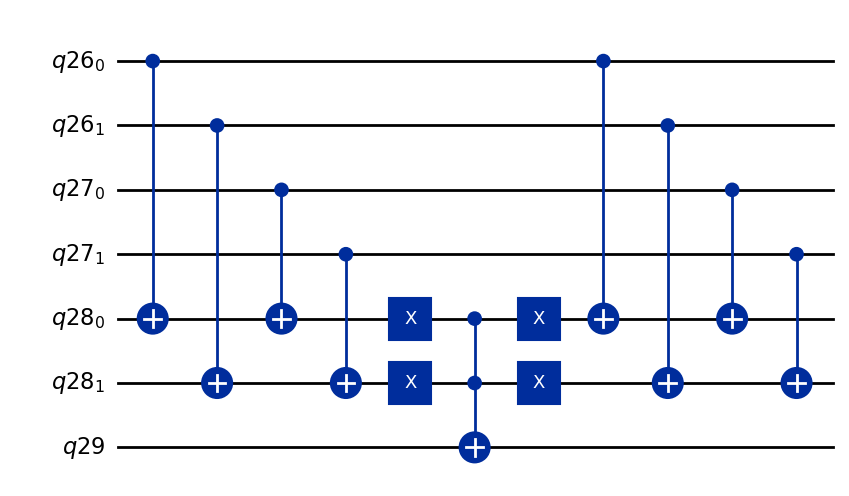

In [30]:
qc = check_equal_circuit(QuantumRegister(2), QuantumRegister(2), QuantumRegister(2), QuantumRegister(1))
qc.draw("mpl")

In [152]:
# EQ is a circuit takes two 2-qbit and one 1-qbit flag
# It sets flag to 1 if the two 2-qbits are equal and to 0 otherwise
EQ = check_equal_circuit(QuantumRegister(2), QuantumRegister(2), QuantumRegister(2), QuantumRegister(1)).to_gate(label="EQ")
EQ_dg = EQ.inverse()
EQ_dg.name = "EQ_dg"

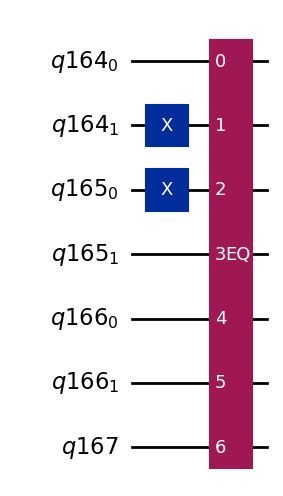

In [204]:
cell1 = QuantumRegister(2)
cell2 = QuantumRegister(2)
ancillas = QuantumRegister(2)
flag = QuantumRegister(1)

qc = QuantumCircuit(cell1, cell2, ancillas, flag)
qc.x(cell1[1])
qc.x(cell2[0])
qc.compose(EQ, qubits=[*cell1, *cell2, *ancillas, flag], inplace=True)
qc.draw("mpl")


In [154]:
Statevector(qc).draw("latex")

<IPython.core.display.Latex object>

## Next we define a circuit that allows one to check if a list of numbers are distinct

In [155]:
"""
qregs is a list of quantum registers, one for each cell, each cell is 2-qbits
eq_ancillas are for using the EQ gate, only need 2 qbits for that
flag is the qbit for the output, it should be set to 1 if there exists two cells are equal and 0 otherwise

returns a circuit that checks if the given row/col/box is valid, that is, all inputs are unique
"""
def check_valid_circuit(qregs : list[QuantumRegister], eq_ancillas : QuantumRegister, ancillas : QuantumRegister, flag : QuantumRegister) -> QuantumCircuit:
    
    qc = QuantumCircuit(*qregs, eq_ancillas, ancillas, flag)

    n = len(qregs)
    # there should be at least 2 (n choose 2) + 1 ancillas
    # we will use each ancilla to store the equality between reg_i and reg_j for some 0 <= i < j < n
    # we will also use the ancillas to take the AND of all comparisons

    anc_idx = 0
    for i in range(n):
        for j in range(i+1, n):
            # set ancillas[anc_idx] to 1 if reg_i and reg_j are equal and 0 otherwise
            qc.compose(EQ, qubits=[*qregs[i], *qregs[j], *eq_ancillas, ancillas[anc_idx]], inplace=True)
            anc_idx += 1

    num_pairs = anc_idx

    assert(num_pairs == int(n * (n - 1) / 2))

    # if there is only one pair, copy that ancilla to flag and uncompute
    if num_pairs == 1:
        qc.cx(ancillas[0], flag)
        qc.compose(EQ, qubits=[*qregs[0], *qregs[1], *eq_ancillas, ancillas[0]], inplace=True)

        return qc

    # combine the markings in ancillas together into the flag
    # take an OR of all the ancillas
    # flag = anc_0 OR ... OR anc_N = NOT ( (NOT anc_0) AND (NOT anc_1) AND ... AND (NOT anc_N) )
    # implement AND using Tofolli gate

    # first negate all the ancillas
    for i in range(num_pairs):
        qc.x(ancillas[i])

    # use Tofolli gates to take the AND
    qc.ccx(ancillas[0], ancillas[1], ancillas[num_pairs])
    for i in range(2, num_pairs):
        qc.ccx(ancillas[i], ancillas[num_pairs+i-2], ancillas[num_pairs+i-1])

    # ancillas[2 * num_pairs - 2] stores the output of the AND
    # we copy that to the flag
    # note: the flag should start out be 0
    qc.cx(ancillas[2 * num_pairs - 2], flag)

    # negate the final answer
    qc.x(flag)

    # uncompute the ancillass used to do Tofolli
    for i in range(num_pairs-1, 1, -1):
        qc.ccx(ancillas[i], ancillas[num_pairs+i-2], ancillas[num_pairs+i-1])
    qc.ccx(ancillas[0], ancillas[1], ancillas[num_pairs])

    # negate back all the ancillas
    for i in range(num_pairs):
        qc.x(ancillas[i])

    # uncompute the ancillas used to check equality of pairs
    anc_idx = num_pairs - 1
    for i in range(n-1, -1, -1):
        for j in range(n-1, i, -1):
            qc.compose(EQ_dg, qubits=[*qregs[i], *qregs[j], *eq_ancillas, ancillas[anc_idx]], inplace=True)
            anc_idx -= 1

    return qc


In [156]:
# test check_valid

# preparing the registers to be compared
def prepare_compare(xs : list[int]):
    num_cell = len(xs)
    num_pairs = int(num_cell * (num_cell - 1) / 2)

    cell_reg = [QuantumRegister(2, name=f'cell_{i}') for i in range(num_cell)]
    eq_anc = QuantumRegister(2, name="eq_anc")
    ancillas = QuantumRegister(2 * num_pairs - 1, name="anc")
    flag = QuantumRegister(1, name='flag')

    qc = QuantumCircuit(*cell_reg, eq_anc, ancillas, flag)
    for i, x in enumerate(xs):
        bin_val = format(x, '02b')
        for j, b in enumerate(bin_val):
            if int(b) == 1:
                qc.x(cell_reg[i][j])

    return qc

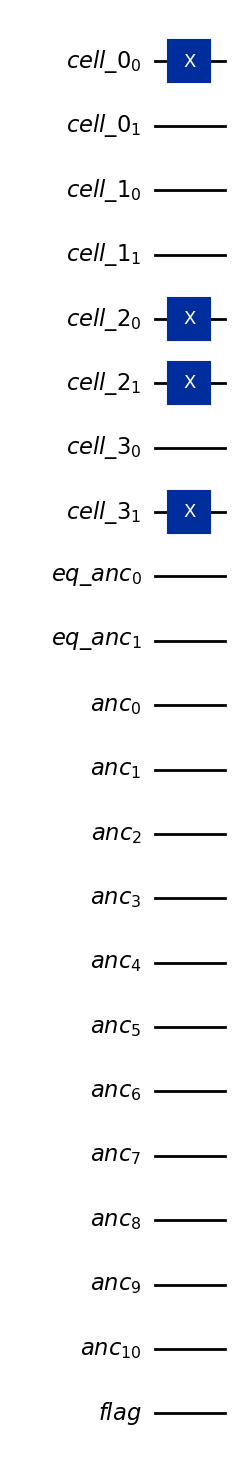

In [205]:
prepare_compare([2, 0, 3, 1]).draw("mpl")

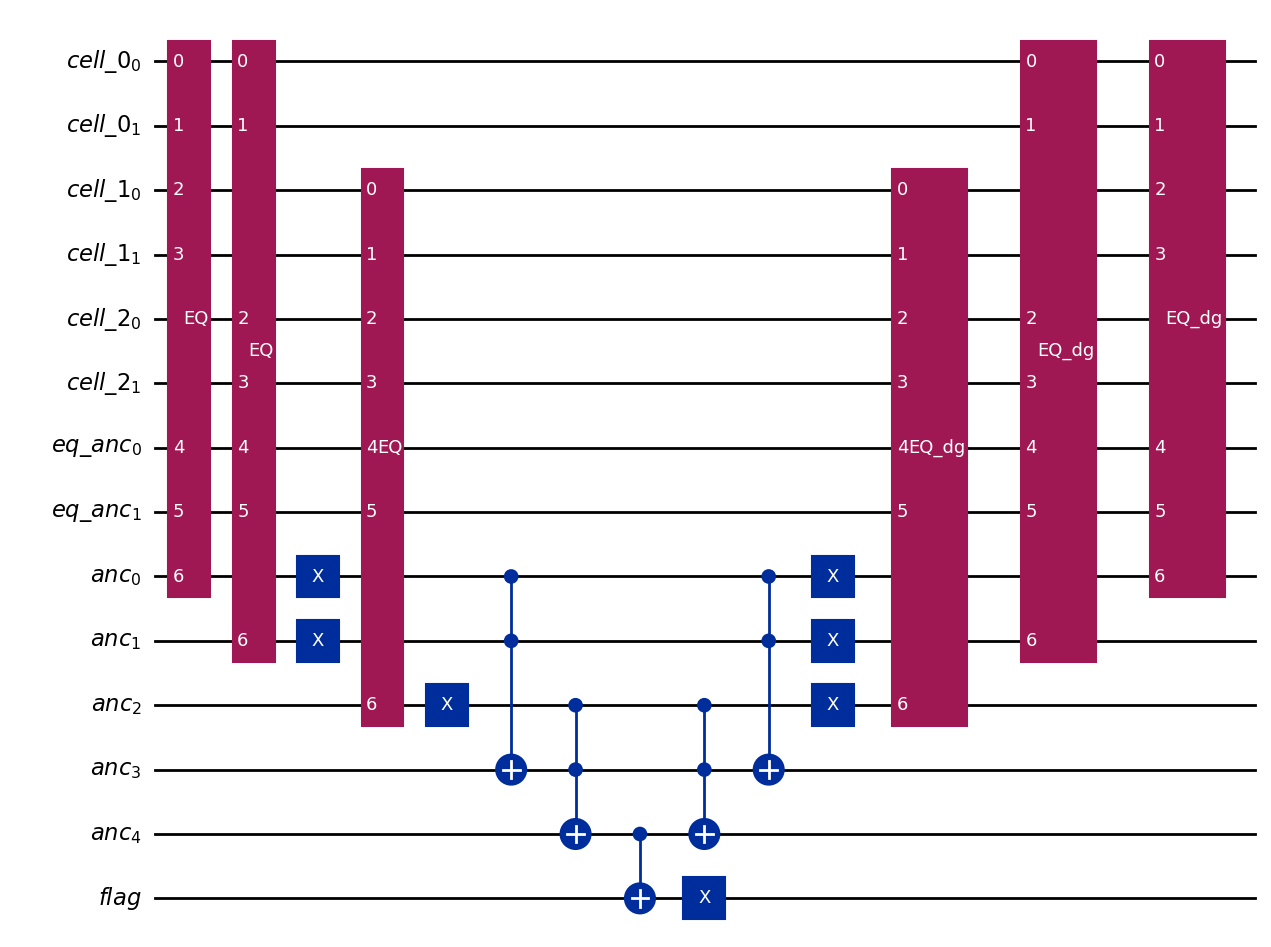

In [157]:
num_cell = 3
num_pairs = int(num_cell * (num_cell - 1) / 2)
cell_reg = [QuantumRegister(2, name=f'cell_{i}') for i in range(num_cell)]

qc = check_valid_circuit(cell_reg, eq_ancillas=QuantumRegister(2, name="eq_anc"), ancillas=QuantumRegister(2 * num_pairs - 1, name="anc"), flag=QuantumRegister(1, name="flag"))
qc.draw("mpl")

In [158]:
Statevector(qc).draw('latex')

<IPython.core.display.Latex object>

### Test the implementation for checking distinct elements

In [159]:
import random
from itertools import product

def test_compare(xs):
    num_cell = len(xs)
    num_pairs = int(num_cell * (num_cell - 1) / 2)
    cell_reg = [QuantumRegister(2, name=f'cell_{i}') for i in range(num_cell)]
    eq_anc = QuantumRegister(2, name="eq_anc")
    ancillas = QuantumRegister(2*num_pairs - 1, name="anc")
    flag = QuantumRegister(1, name="flag")

    prepare_qc = prepare_compare(xs)
    prepare_qc.compose(check_valid_circuit(cell_reg, eq_anc, ancillas, flag), inplace=True)

    return prepare_qc

def compare_case1():
    print("Testing 1 pair")
    for i in range(4):
        for j in range(4):
            qc = test_compare([i, j])
            res = int(Statevector(qc).measure()[0][0])
            assert(res == (i == j))
    print("passed")

    print("Testing 3 elements")
    all_tuples = list(product(range(4), repeat=3))
    sampled = random.sample(all_tuples, 3)

    for tpl in sampled:
        lst = list(tpl)
        print("  testing: ", lst)
        qc = test_compare(lst)
        res = int(Statevector(qc).measure()[0][0])
        assert(res != (len(lst) == len(set(lst))))
    print("passed")

    print("Testing 4 elements")
    all_tuples = list(product(range(4), repeat=4))
    sampled = random.sample(all_tuples, 1)

    for tpl in sampled:
        lst = list(tpl)
        print("  testing: ", lst)
        qc = test_compare(lst)
        res = int(Statevector(qc).measure()[0][0])
        assert(res != (len(lst) == len(set(lst))))
    print("passed")

In [140]:
compare_case1()

Testing 1 pair
passed
Testing 3 elements
  testing:  [0, 1, 2]
  testing:  [2, 0, 1]
  testing:  [3, 0, 3]
passed
Testing 4 elements
  testing:  [3, 2, 1, 2]


MemoryError: Unable to allocate 256. TiB for an array with shape (4194304, 4194304) and data type complex128

In [160]:
qc = test_compare([1, 2, 3, 1])
Statevector(qc).draw("latex")

<IPython.core.display.Latex object>

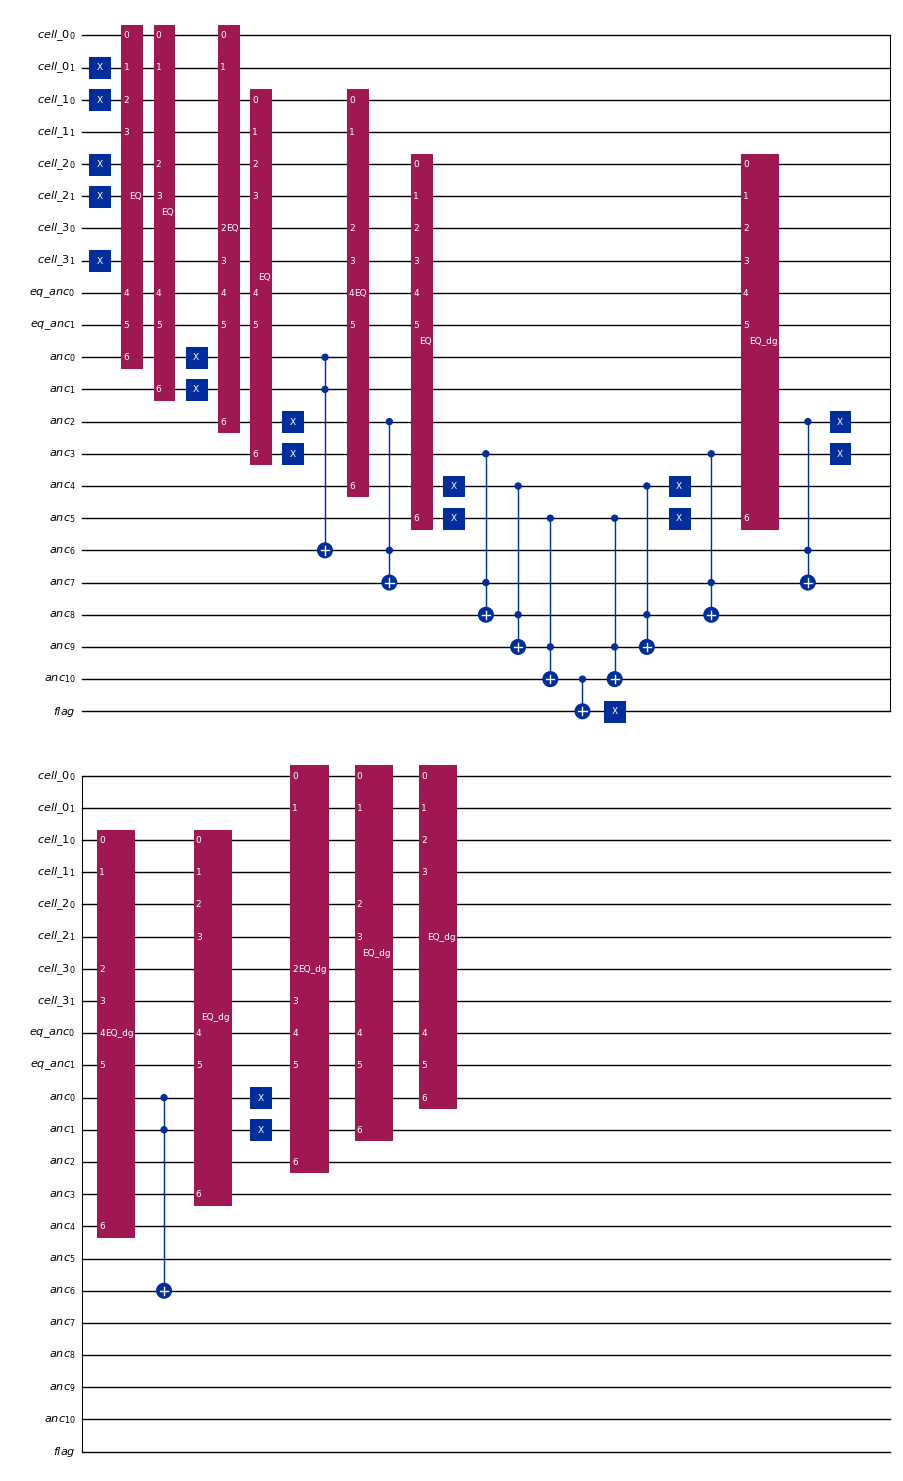

In [161]:
qc.draw("mpl", scale=0.5)

## Defining the oracle given a Sudoku board

In [230]:
"""
format of the 4x4 board: a list of integers, a nonnegative number for filled in entry, -1 represents blanks
returns a oracle for that board: that is a quantum circuit verifies whether filling in the blanks solves the sudoku
"""
def get_oracle(board):
    num_of_holes = board.count(-1)

    # each 2 qubit represets a number between 0 and 3
    # |00>: 0, |01>: 1, |10>: 2, |11>: 3
    cell_reg = [QuantumRegister(2, name=f'cell_{i}') for i in range(16)]
    eq_anc = QuantumRegister(2, 'eq_anc')

    # need ancilla for check 6 pairs -> 13 ancillas
    ancilla_reg = QuantumRegister(13, 'anc')
    # also need registers to store the results of each check -> 12 checks
    flag_reg = [QuantumRegister(1, name=f'flag_{i}') for i in range(12)]

    output_reg = QuantumRegister(1, 'output')

    qc = QuantumCircuit(*cell_reg, eq_anc, ancilla_reg, *flag_reg, output_reg)

    # set known entries
    for i, cell in enumerate(board):
        if cell != -1:
            # get the binary representation of the known cell
            cell_bin = format(cell, '02b')
            for j, bit in enumerate(cell_bin):
                if int(bit) == 1:
                    qc.x(cell_reg[i][j])

    # check the rows are valid
    flag_idx = 0

    row_check_gates = []
    column_check_gates = []
    for i in range(4):
        row = check_valid_circuit(
            qregs=[cell_reg[4*i+0], cell_reg[4*i+1], cell_reg[4*i+2], cell_reg[4*i+3]],
            eq_ancillas=eq_anc,
            ancillas=ancilla_reg,
            flag=flag_reg[flag_idx]).to_gate(label=f'row_{i}')

        row_check_gates.append(row)

        qc.compose(
            row,
            qubits=[*cell_reg[4*i+0], *cell_reg[4*i+1], *cell_reg[4*i+2], *cell_reg[4*i+3],
            *eq_anc, *ancilla_reg, *flag_reg[flag_idx]], inplace=True)

        flag_idx += 1

    # check the columns are valid
    for i in range(4):
        col = check_valid_circuit(
            qregs=[cell_reg[i], cell_reg[4+i], cell_reg[8+i], cell_reg[12+i]],
            eq_ancillas=eq_anc,
            ancillas=ancilla_reg,
            flag=flag_reg[flag_idx])

        qc.compose(
            col,
            qubits=[*cell_reg[i], *cell_reg[4+i], *cell_reg[8+i], *cell_reg[12+i],
            *eq_anc, *ancilla_reg, *flag_reg[flag_idx]], inplace=True)

        flag_idx += 1

    # check each 2x2
    box1 = check_valid_circuit(
        qregs=[cell_reg[0], cell_reg[1], cell_reg[2], cell_reg[3]],
        eq_ancillas=eq_anc,
        ancillas=ancilla_reg,
        flag=flag_reg[flag_idx])

    qc.compose(
        box1,
        qubits=[*cell_reg[0], *cell_reg[1], *cell_reg[2], *cell_reg[3],
        *eq_anc, *ancilla_reg, *flag_reg[flag_idx]], inplace=True)

    flag_idx += 1

    box2 = check_valid_circuit(
        qregs=[cell_reg[2], cell_reg[3], cell_reg[6], cell_reg[7]],
        eq_ancillas=eq_anc,
        ancillas=ancilla_reg,
        flag=flag_reg[flag_idx])

    qc.compose(
        box2,
        qubits=[*cell_reg[2], *cell_reg[3], *cell_reg[6], *cell_reg[7],
        *eq_anc, *ancilla_reg, *flag_reg[flag_idx]], inplace=True)

    flag_idx += 1

    box3 = check_valid_circuit(
        qregs=[cell_reg[8], cell_reg[9], cell_reg[12], cell_reg[13]],
        eq_ancillas=eq_anc,
        ancillas=ancilla_reg,
        flag=flag_reg[flag_idx])

    qc.compose(
        box3,
        qubits=[*cell_reg[8], *cell_reg[9], *cell_reg[12], *cell_reg[13],
        *eq_anc, *ancilla_reg, *flag_reg[flag_idx]], inplace=True)

    flag_idx += 1

    box4 = check_valid_circuit(
        qregs=[cell_reg[10], cell_reg[11], cell_reg[14], cell_reg[15]],
        eq_ancillas=eq_anc,
        ancillas=ancilla_reg,
        flag=flag_reg[flag_idx])

    qc.compose(
        box4,
        qubits=[*cell_reg[10], *cell_reg[11], *cell_reg[14], *cell_reg[15],
        *eq_anc, *ancilla_reg, *flag_reg[flag_idx]], inplace=True)

    flag_idx += 1

    assert(flag_idx == 12)

    # do an OR on all flags

    return qc

In [231]:
get_oracle(board_1).draw("mpl")

In [170]:
def get_preparation(board):
    num_of_holes = board.count(-1)
    input_cells = [QuantumRegister(2, name=f'input_{i}') for i in range(num_of_holes)]
    qc = QuantumCircuit(*input_cells, name="State preparation")
    for reg in input_cells:
        qc.h(reg)

    return qc

In [197]:
def diffuser(board):
    num_of_holes = board.count(-1)

    input_cells = [QuantumRegister(size=2, name=f'input_{i}') for i in range(num_of_holes)]

    diffuser_circuit = QuantumCircuit(*input_cells, name="diffuser")

    # S = H^{n} . X^{n} . C^{n-1}Z . X^{n} . H^{n}

    diffuser_circuit.compose(get_preparation(board).to_gate(), inplace=True)

    for reg in input_cells:
        diffuser_circuit.x(reg)
        diffuser_circuit.h(reg)

    ## mcz = H . mcx . H
    controls = [ reg[0] for reg in input_cells[:-1]] + [ reg[1] for reg in input_cells[:-1]] + [input_cells[-1][0]]
    diffuser_circuit.mcx(control_qubits=controls, target_qubit=input_cells[-1][1])

    for reg in input_cells:
        diffuser_circuit.h(reg)
        diffuser_circuit.x(reg)

    diffuser_circuit.compose(get_preparation(board).to_gate().inverse(), inplace=True)

    return diffuser_circuit

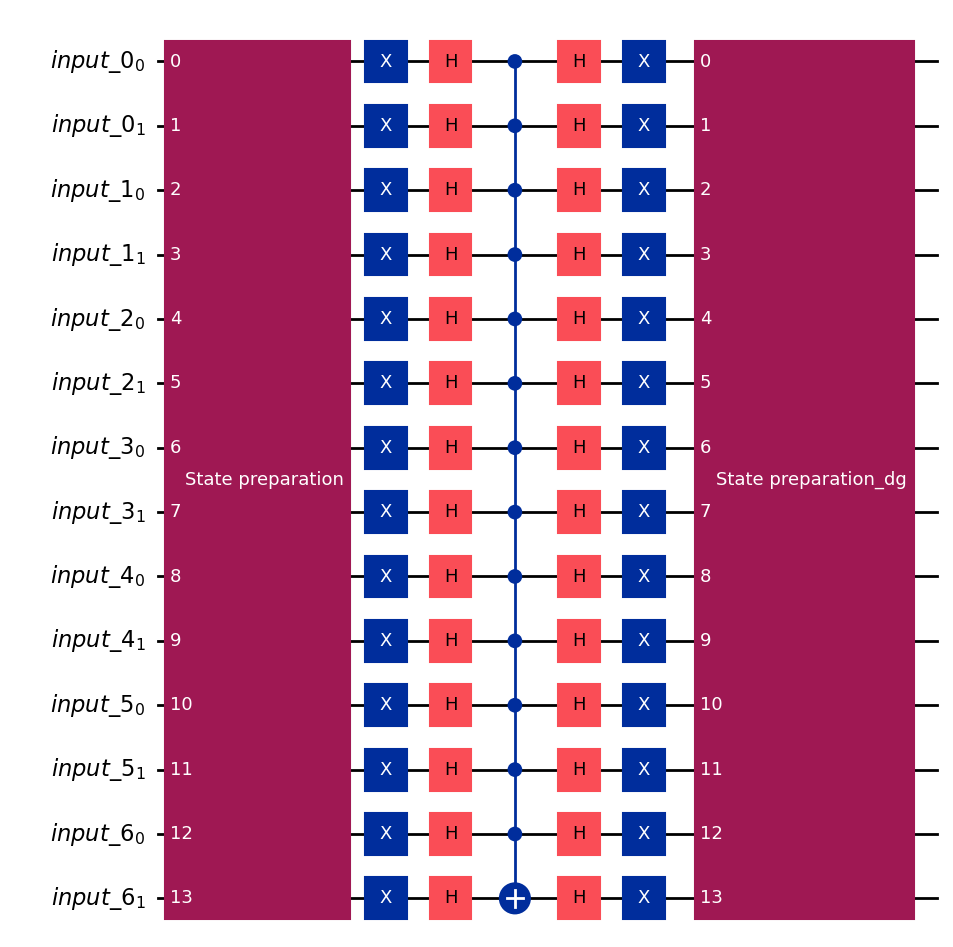

In [198]:
qc = diffuser(board_1)
qc.draw("mpl")

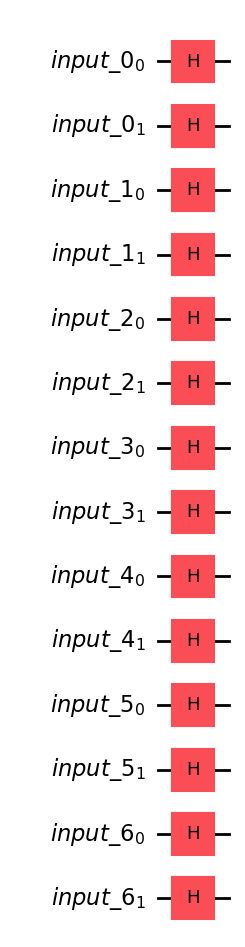

In [176]:
# 2 0 3 1
# 1 * * 0
# 0 * * *
# 3 * * 2
board_1 = [2, 0, 3, 1, 1, -1, -1, 0, 0, -1, -1, -1, 3, -1, -1, 2]

qc = get_preparation(board_1)
qc.draw(output="mpl")